# Lets install flax first 
- Colab does not come default with flax suprising, hmm install first

In [1]:
!pip install flax

# Lets settle the import first
- Since we need a dataset we have to borrow from tensorflow datasets

In [2]:
import jax.numpy as jnp
import jax

from flax import linen as nn
from flax.training import train_state
import flax
import optax # Optimizers are here

import tensorflow_datasets as tfds
import numpy as np

# Model metrics
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, auc, roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Lets import our data first
- Lets use a popular datasets fashion_mnist
- We can train a simple cnn to test our model
- We can do a bit of EDA on it as well

In [3]:
(train_ds, valid_ds, test_ds), info_ds = tfds.load(
    'fashion_mnist', split=['train', 'test[:50]', 'test[50:]'], data_dir='data',
    with_info=True
)

In [4]:
# Lets do a bit of eda
train_df = tfds.as_dataframe(train_ds, info_ds)

In [5]:
label_names = info_ds.features['label'].names
label_index = dict([(index, name) for index, name in enumerate(label_names)])

In [6]:
train_df['label_names'] = train_df['label'].apply(lambda x: label_index[x])

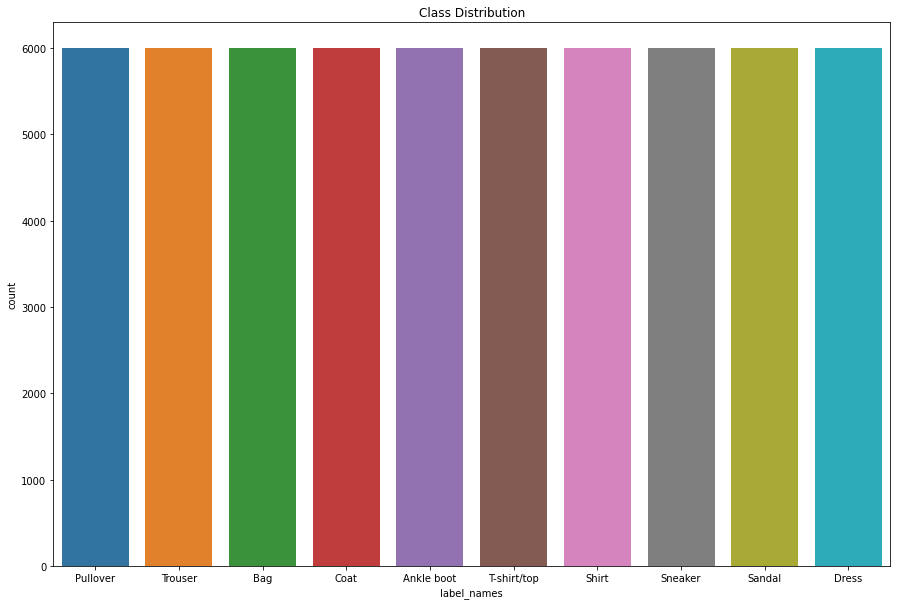

In [7]:
plt.figure(figsize=(15, 10))
plt.title('Class Distribution')
sns.countplot(data=train_df, x='label_names');

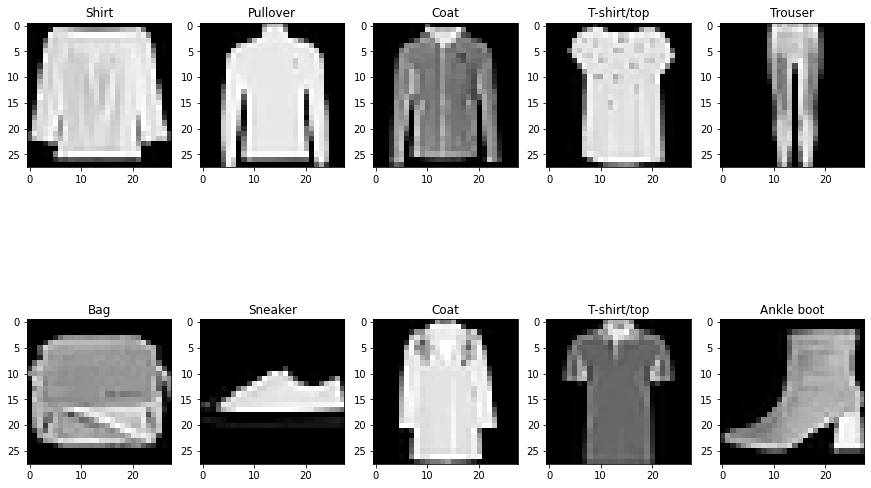

In [8]:
plt.figure(figsize=(15, 10))

for index, data in enumerate(train_ds.shuffle(100).take(10)):
  plt.subplot(2, 5, index + 1)
  plt.title(label_index[data['label'].numpy()])
  plt.imshow(data['image'][:, :, 0], cmap='gray')

In [9]:
# Lets preapre the data for jax
train_image = jnp.float32(list(map(lambda x: x['image'], train_ds))) / 255.
val_image = jnp.float32(list(map(lambda x: x['image'], valid_ds))) / 255.
test_image = jnp.float32(list(map(lambda x: x['image'], test_ds))) / 255.

train_label = np.array(list(map(lambda x:x['label'], train_ds)))
val_label = np.array(list(map(lambda x:x['label'], valid_ds)))
test_label = np.array(list(map(lambda x:x['label'], test_ds)))

# Lets build our model
- Similar to how torch uses the nn.Module, we will use a jax version
- But the naming and passing in features are closer to that of tensorflow and keras

In [10]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

    x = nn.Conv(64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

    x = nn.Conv(128, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

    x = x.reshape((x.shape[0], -1)) # Hmm no flatten layer , aw well
    x = nn.Dense(256)(x)
    x = nn.relu(x)
    x = nn.Dense(10)(x)

    return x

In [11]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [12]:
cnn = CNN()
params = cnn.init(init_rng, jnp.ones([1, 28, 28, 1]))['params']

In [13]:
optim = optax.adam(learning_rate=1e-4, eps=1e-8)

In [14]:
state = train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=optim)

# Train loop
- Like in tensorflow gradients api and pytorch we can write our custom loop steps
- Similar to tensorflow function we will use the jax jit function to optimize the jax code

In [15]:
def compute_metrics(logits, labels):
  loss = jnp.mean(
      optax.softmax_cross_entropy(
          logits, jax.nn.one_hot(labels, num_classes=10)
      )
  )
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return {
      'loss': loss,
      'accuracy': accuracy
  }

In [16]:
# Step functions
@jax.jit
def train_step(state, image_batch, label_batch):
  def loss_fn(params):
    logits = CNN().apply({'params': params}, image_batch)
    loss = jnp.mean(
        optax.softmax_cross_entropy(
            logits=logits,
            labels=jax.nn.one_hot(label_batch, num_classes=10)
        )
    )

    return loss, logits
  
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits, label_batch)

  return state, metrics

@jax.jit
def eval_step(params, image_batch, label_batch):
  logits = CNN().apply({'params': params}, image_batch)
  return compute_metrics(logits, label_batch)

In [17]:
# Train epoch
def train_epoch(state, image_batch, label_batch, batch_size, epoch, rng):
  train_size = len(image_batch)
  steps_per_epoch = train_size // batch_size

  perms = jax.random.permutation(rng, train_size)
  perms = perms[:steps_per_epoch * batch_size]
  perms = perms.reshape((steps_per_epoch, batch_size))

  batch_metrics = []

  for perm in perms:
    state, metrics = train_step(
        state, image_batch[perm, ...], label_batch[perm, ...]
    )
    batch_metrics.append(metrics)

  training_batch_metrics = jax.device_get(batch_metrics)
  training_epoch_metrics = {
      k: np.mean([metrics[k] for metrics in training_batch_metrics])
      for k in training_batch_metrics[0]}

  print('Training - epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, training_epoch_metrics['loss'], training_epoch_metrics['accuracy'] * 100))

  return state, training_epoch_metrics

In [18]:
def eval_model(params, image_batch, label_batch):
  metrics = eval_step(params, image_batch, label_batch)
  metrics = jax.device_get(metrics)
  eval_summary = jax.tree_map(lambda x: x.item(), metrics)
  return eval_summary['loss'], eval_summary['accuracy']

In [19]:
# The acutal training loop
for epoch in tqdm(range(10)):
  # Training
  rng, input_rng = jax.random.split(rng)
  state, train_metrics = train_epoch(state, train_image, train_label, 64, epoch, input_rng)

  # Eval
  test_loss, test_acc = eval_model(state.params, val_image, val_label)
  print('Testing - epoch: %d, loss: %.2f, accuracy: %.2f' % (epoch, test_loss, test_acc * 100))


Training - epoch: 0, loss: 0.6425, accuracy: 77.91
Testing - epoch: 0, loss: 0.38, accuracy: 84.00
Training - epoch: 1, loss: 0.3922, accuracy: 86.01
Testing - epoch: 1, loss: 0.25, accuracy: 92.00
Training - epoch: 2, loss: 0.3373, accuracy: 87.94
Testing - epoch: 2, loss: 0.20, accuracy: 94.00
Training - epoch: 3, loss: 0.3115, accuracy: 88.75
Testing - epoch: 3, loss: 0.16, accuracy: 100.00
Training - epoch: 4, loss: 0.2881, accuracy: 89.65
Testing - epoch: 4, loss: 0.17, accuracy: 98.00
Training - epoch: 5, loss: 0.2710, accuracy: 90.14
Testing - epoch: 5, loss: 0.13, accuracy: 98.00
Training - epoch: 6, loss: 0.2583, accuracy: 90.72
Testing - epoch: 6, loss: 0.09, accuracy: 98.00
Training - epoch: 7, loss: 0.2453, accuracy: 91.15
Testing - epoch: 7, loss: 0.12, accuracy: 100.00
Training - epoch: 8, loss: 0.2331, accuracy: 91.65
Testing - epoch: 8, loss: 0.12, accuracy: 96.00
Training - epoch: 9, loss: 0.2234, accuracy: 91.93
Testing - epoch: 9, loss: 0.17, accuracy: 94.00



# Model Evaluation
- Lets make a forward pass with the jax/flax model
- Seems like gpu is automatically allocated, therefore its not necessary to load like torch, seems to function very close to tensorflow

In [20]:
# Forward pass - quite different from torch
y_pred = cnn.apply({'params': state.params}, test_image).argmax(axis=1)

In [21]:
print(classification_report(test_label, y_pred, target_names=label_names))

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.84      0.86       993
     Trouser       0.99      0.98      0.98       998
    Pullover       0.92      0.77      0.84       995
       Dress       0.88      0.93      0.90       996
        Coat       0.81      0.86      0.84       990
      Sandal       0.99      0.97      0.98       995
       Shirt       0.72      0.78      0.74       998
     Sneaker       0.93      0.98      0.96       991
         Bag       0.99      0.97      0.98       999
  Ankle boot       0.97      0.95      0.96       995

    accuracy                           0.90      9950
   macro avg       0.91      0.90      0.90      9950
weighted avg       0.91      0.90      0.90      9950



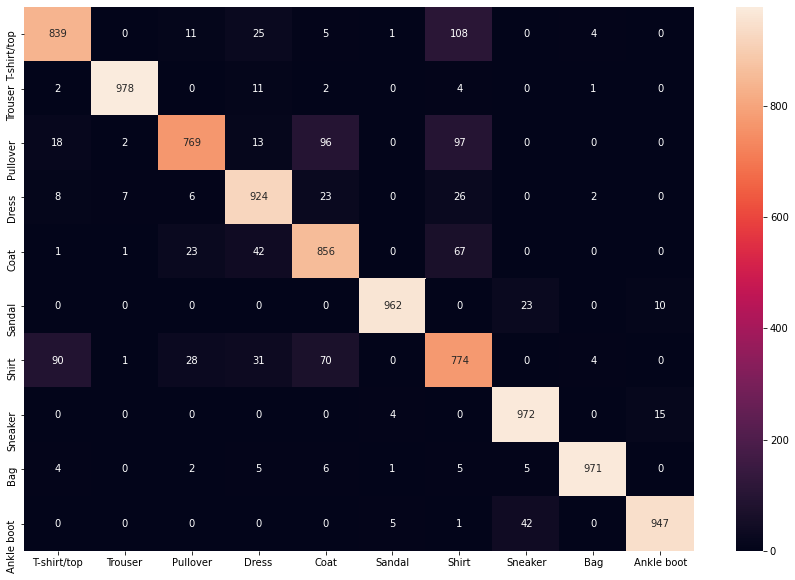

In [22]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(test_label, y_pred), annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names)

In [23]:
print('MCC Acc: {:.2f}'.format(matthews_corrcoef(test_label, y_pred) * 100))

MCC Acc: 89.32
